In [1]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

sentence = "James is working at Disney in London"
# 토큰화 후 품사 태깅
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


[nltk_data] Downloading package punkt to /home/kjw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kjw/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/kjw/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/kjw/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
train_url="https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt"
urllib.request.urlretrieve(train_url, filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [5]:
print(f"전체 샘플 개수: {len(tagged_sentences)}")
print(f'첫번째 샘플: {tagged_sentences[0]}')

전체 샘플 개수: 14041
첫번째 샘플: [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [6]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 문장 샘플을 1개씩 불러온다.
    # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장
    sentence, tag_info = zip(*tagged_sentence) 
    
    # 각 샘플에서 단어 정보만 저장
    sentences.append(list(sentence)) 
    
    # 각 샘플에서 개체명 태깅 정보만 저장
    ner_tags.append(list(tag_info)) 
    
print(f'첫번째 샘플의 문장: {sentences[0]}')
print(f'첫번째 샘플의 레이블: {ner_tags[0]}')

첫번째 샘플의 문장: ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
첫번째 샘플의 레이블: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이:113
샘플의 평균 길이: 14.501887329962253


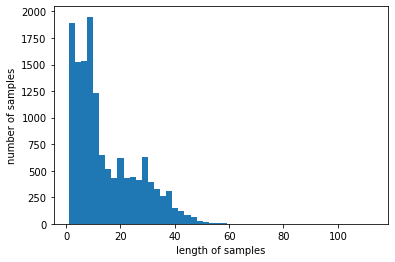

In [7]:
print(f'샘플의 최대 길이:{max(len(sentence) for sentence in sentences)}')
print(f'샘플의 평균 길이: {sum(map(len, sentences))/len(sentences)}')
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
vocab_size = 4000
# src_tokenizer: 문장 데이터
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

#tar_tokenizer: 개체명 태깅 정보
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

tag_size = len(tar_tokenizer.word_index) + 1
print(f'단어 집합의 크기: {vocab_size}')
print(f'개체명 태깅 정보 집합의 크기: {tag_size}')

# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

print(f'첫번째 샘플의 문장: {X_train[0]}')
print(f'첫번째 샘플의 레이블: {y_train[0]}')
#print(src_tokenizer.word_index)

단어 집합의 크기: 4000
개체명 태깅 정보 집합의 크기: 10
첫번째 샘플의 문장: [989, 1, 205, 629, 7, 3939, 216, 1, 3]
첫번째 샘플의 레이블: [4, 1, 7, 1, 1, 1, 7, 1, 1]


In [9]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print(f'기존 문장: {sentences[0]}')
print(f'빈도수가 낮은 단어가 OOV 처리된 문장: {decoded}')

기존 문장: ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장: ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [10]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=.4, 
                                                    random_state=777)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                    test_size=.5, 
                                                    random_state=777)

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)
y_val = to_categorical(y_val, num_classes=tag_size)

print(f'훈련 샘플 문장의 크기: {X_train.shape}')
print(f'훈련 샘플 레이블의 크기: {y_train.shape}')
print(f'검증 샘플 문장의 크기: {X_val.shape}')
print(f'검증 샘플 레이블의 크기: {y_val.shape}')
print(f'테스트 샘플 문장의 크기: {X_test.shape}')
print(f'테스트 샘플 레이블의 크기: {y_test.shape}')

훈련 샘플 문장의 크기: (8424, 70)
훈련 샘플 레이블의 크기: (8424, 70, 10)
검증 샘플 문장의 크기: (2809, 70)
검증 샘플 레이블의 크기: (2809, 70, 10)
테스트 샘플 문장의 크기: (2808, 70)
테스트 샘플 레이블의 크기: (2808, 70, 10)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(0.001), 
              metrics=['accuracy'])

history= model.fit(X_train, y_train, 
                   batch_size=128, 
                   epochs=30, validation_data=(X_val, y_val))

2022-10-04 21:50:55.051958: I tensorflow/stream_executor/stream.cc:4442] [stream=0x55e16e389160,impl=0x55e16e389450] INTERNAL: stream did not block host until done; was already in an error state


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run Qr: stream did not block host until done; was already in an error state [Op:Qr]

In [ ]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , 
               fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

plot_history(history)


In [ ]:
i = 15 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 확률 벡터를 정수 레이블로 변경.
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], 
                                      index_to_ner[tag].upper(), 
                                      index_to_ner[pred].upper()))

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 
            #  1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. '
            # PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))